## Global Terrorism Attribution Predictor

In this project I...

In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi
import pandas as pd
import matplotlib.pyplot as plt
data_path = "./data"

In [2]:
api = KaggleApi()
api.authenticate()
api.dataset_download_files("START-UMD/gtd", quiet=False, path=data_path)

gtd.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
skipcols=lambda x: x not in ["extended", "addnotes", "scite1", "scite2", "scite3", "dbsource"]
usecols=["eventid",
         "imonth",
         "iday",
         "country",
         "region",
         "provstate",
         "city",
         "attacktype1",
         "targtype1",
         "targsubtype1",
         "natlty1",
         "gname",
         "weaptype1",
         "ransom"]

pd.set_option('display.max_columns', None) 
data = pd.read_csv(data_path + "/gtd.zip",
                        encoding = "ISO-8859-1",
                        compression='zip',
                        usecols=usecols)

In [21]:
data['attacktype1'] = data.attacktype1.astype('category')
data['targtype1'] = data.targtype1.astype('category')
data['targsubtype1'] = data.targsubtype1.astype('category')
data['natlty1'] = data.natlty1.astype('category')
data['weaptype1'] = data.weaptype1.astype('category')
data['ransom'] = data.ransom.astype('category')

In [27]:
data.head()

,eventid,imonth,iday,country,region,provstate,city,attacktype1,targtype1,targsubtype1,natlty1,gname,weaptype1,ransom
0,197000000001,7,2,58,2,NaN,Santo Domingo,1,14,68.0,58.0,MANO-D,13,0.0
1,197000000002,0,0,130,1,Federal,Mexico city,6,7,45.0,21.0,23rd of September Communist League,13,1.0
2,197001000001,1,0,160,5,Tarlac,Unknown,1,10,54.0,217.0,Unknown,13,0.0
3,197001000002,1,0,78,8,Attica,Athens,3,7,46.0,217.0,Unknown,6,0.0
4,197001000003,1,0,101,4,Fukouka,Fukouka,7,7,46.0,217.0,Unknown,8,0.0


In [26]:
data.describe()

,eventid,imonth,iday,country,region
count,1.816910e+05,181691.000000,181691.000000,181691.000000,181691.000000
mean,2.002705e+11,6.467277,15.505644,131.968501,7.160938
std,1.325957e+09,3.388303,8.814045,112.414535,2.933408
min,1.970000e+11,0.000000,0.000000,4.000000,1.000000
25%,1.991021e+11,4.000000,8.000000,78.000000,5.000000
50%,2.009022e+11,6.000000,15.000000,98.000000,6.000000
75%,2.014081e+11,9.000000,23.000000,160.000000,10.000000
max,2.017123e+11,12.000000,31.000000,1004.000000,12.000000


In [18]:
attributed = data.loc[data['gname'] != "Unknown"]

In [28]:
attributed.head()

,eventid,imonth,iday,country,region,provstate,city,attacktype1,targtype1,targsubtype1,natlty1,gname,weaptype1,ransom
0,197000000001,7,2,58,2,NaN,Santo Domingo,1,14,68.0,58.0,MANO-D,13,0.0
1,197000000002,0,0,130,1,Federal,Mexico city,6,7,45.0,21.0,23rd of September Communist League,13,1.0
5,197001010002,1,1,217,1,Illinois,Cairo,2,3,22.0,217.0,Black Nationalists,5,0.0
6,197001020001,1,2,218,3,Montevideo,Montevideo,1,3,25.0,218.0,Tupamaros (Uruguay),5,0.0
8,197001020003,1,2,217,1,Wisconsin,Madison,7,4,28.0,217.0,New Year's Gang,8,0.0


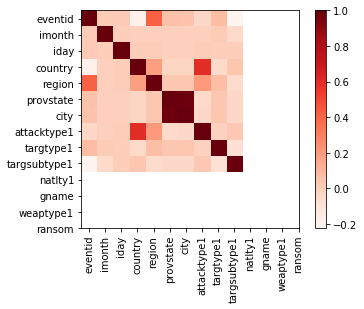

In [29]:
plt.imshow(attributed.corr(), cmap=plt.cm.Reds, interpolation='nearest')
plt.colorbar()
tick_marks = [i for i in range(len(attributed.columns))]
plt.xticks(tick_marks, attributed.columns, rotation='vertical')
plt.yticks(tick_marks, attributed.columns)
plt.show()